In [12]:
import numpy as np
import pickle
from astropy.io import fits
import gausspy.gp as gp
import matplotlib.pyplot as plt
from importlib import reload


In [13]:
def gaussian(amp, fwhm, mean):
    return lambda x: amp * np.exp(-4. * np.log(2) * (x-mean)**2 / fwhm**2)


In [14]:
## Read fits datacube and save in GaussPy format

# Specify necessary parameters
FILENAME_DATA = '/home/tcc/data/CH3OCHO.fits'
FILENAME_DATA_GAUSSPY = 'cube.pickle'
RMS = 0.01

Ihdu = fits.open(FILENAME_DATA)
cube = Ihdu[0].data

#print(Ihdu[0].header)
#print(cube.shape)

header = Ihdu[0].header
naxis1 = Ihdu[0].header['naxis1']
naxis2 = Ihdu[0].header['naxis2']
naxis3 = Ihdu[0].header['naxis3']
crpix3 = Ihdu[0].header['crpix3']
cdelt3 = Ihdu[0].header['cdelt3']
crval3 = Ihdu[0].header['crval3']
ctype3 = Ihdu[0].header['ctype3']


velocity_array = np.zeros( naxis3 )
velocity_array = crval3 + ( np.arange(naxis3) + 1 - crpix3 ) * cdelt3

# initialize
data   = {} #dict
errors = np.ones(cube.shape[1]) * RMS
chan   = velocity_array/1e3
#np.arange(cube.shape[1])


# cycle through each spectrum
for xpix in range(203,205):
    for ypix in range(268,270):

        # get the spectrum
        spectrum = cube[0][:, ypix, xpix]
        #print(spectrum.shape)

        # get the spectrum location
        location = np.array((xpix, ypix))


        # Enter results into GaussPy-friendly dataset
        data['data_list'] = data.get('data_list', []) + [spectrum]
        data['x_values']  = data.get('x_values', []) + [chan]
        data['errors']    = data.get('errors', [])   + [errors]
        data['location']  = data.get('location', []) + [location]

        
#print(data['errors'])
# Save decomposition information
pickle.dump(data, open(FILENAME_DATA_GAUSSPY, 'wb'))

In [20]:
# Decompose multiple Gaussian dataset using AGD with TRAINED alpha

# Specify necessary parameters


#g = gp.GaussianDecomposer()

FILENAME_DATA_GAUSSPY = 'cube.pickle'
FILENAME_DATA_DECOMP = 'cube_decomposed.pickle'

def decomposition(FILENAME_DATA_GAUSSPY):
    
    alpha1 = 0.1
    alpha2 = 12.0
    snr_thresh = 3.0
    
    g = gp.GaussianDecomposer()
    # Setting AGD parameters
    g.set('phase', 'two')
    g.set('SNR_thresh', [snr_thresh, snr_thresh])
    g.set('alpha1', alpha1)
    g.set('alpha2', alpha2)

    decomposed_data = g.batch_decomposition(FILENAME_DATA_GAUSSPY)
    
    FILENAME_DATA_DECOMP = 'cube_decomposed.pickle'
    pickle.dump(decomposed_data, open(FILENAME_DATA_DECOMP, 'wb'))
    
    return FILENAME_DATA_DECOMP

FILENAME_DATA_DECOMP = decomposition(FILENAME_DATA_GAUSSPY)

using 3 out of 4 cpus
   ---->   0


  0%|                                               | 0.00/3.00 [00:00<?, ?it/s]

   ---->     ---->      ---->  1 
 32



100%|████████████████████████████████████████| 3.00/3.00 [00:05<00:00, 1.78s/it]
3it [00:00, 44938.97it/s]

SUCCESS
100 finished.%


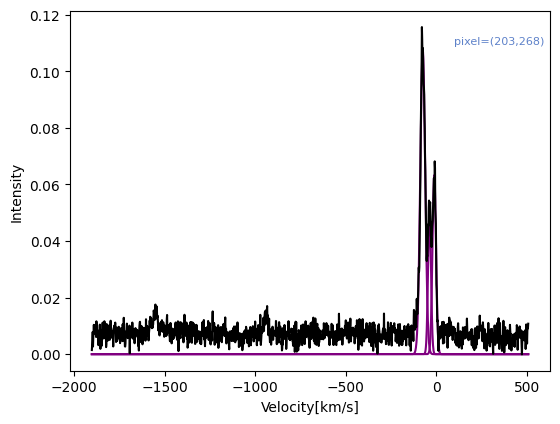

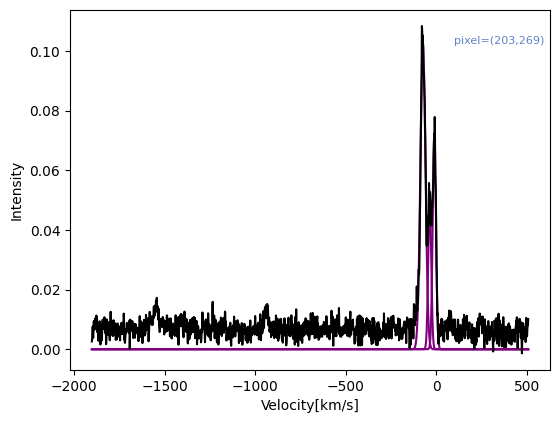

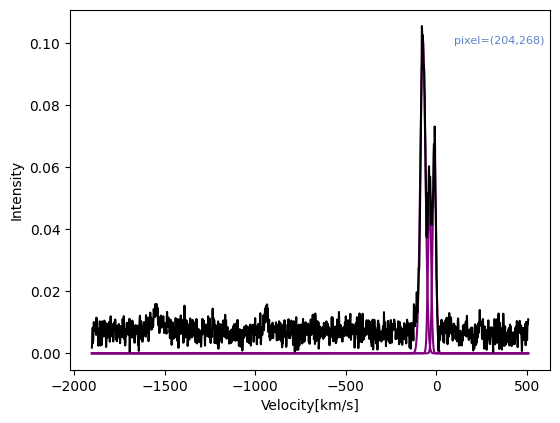

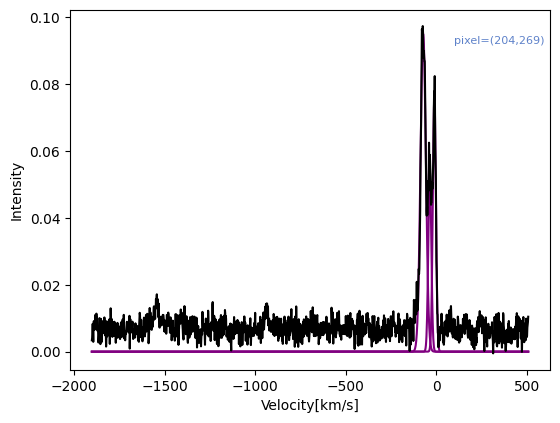

In [16]:
## Plot GaussPy results for selections of cube LOS

# load the original data
FILENAME_DATA_GAUSSPY = 'cube.pickle'
data = pickle.load(open(FILENAME_DATA_GAUSSPY,'rb'))

# load decomposed data
#FILENAME_DATA_DECOMP = 'cube_decomposed.pickle'
data_decomposed = pickle.load(open(FILENAME_DATA_DECOMP,'rb'))

#print(data_decomposed['means_fit'])


for index in range(len(data_decomposed['means_fit'])):
    # original data
    x = data['x_values'][index]
    y = data['data_list'][index]
    pix = data['location'][index]
    
    # Fitting parameter
    fit_fwhms = data_decomposed['fwhms_fit'][index]
    fit_means = data_decomposed['means_fit'][index]
    fit_amps  = data_decomposed['amplitudes_fit'][index]
    #print(fit_means)
   
    fig = plt.figure()
    ax  = fig.add_axes([0.12, 0.1, 0.75, 0.75])
    
    if len(fit_amps) > 0.:
        for j in range(len(fit_amps)):
            amp, fwhm, mean =  fit_amps[j], fit_fwhms[j], fit_means[j]
            yy = amp * np.exp(-4. * np.log(2) * (x-mean)**2 / fwhm**2)
            plt.plot(x,yy,'-',lw=1.5,color='purple')
    
    plt.plot(x, y, color='black')
    #ax.set_xlim(0,1532)
    plt.xlabel('Velocity[km/s]')
    plt.ylabel('Intensity')
    
    xpix = pix[0]
    ypix = pix[1]
    label_string = f'pixel=({xpix},{ypix})'
    
    plt.text(0.8, 0.9, # location of the text label
             label_string, # content of the label
             color = (0.1, 0.3, 0.7, 0.7),
             verticalalignment = 'bottom', horizontalalignment = 'left',
             transform = ax.transAxes, # use relative coordinates
             fontsize = 8)
    
    outPDF_filename = f'decomposed({xpix},{ypix}).pdf'
    plt.savefig(outPDF_filename, transparent=True)
    plt.show()